In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-09-16 09:09:59,202 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
files = glob.glob('/artemis/readout/2016-09-13_1540*')

In [5]:
files

['/artemis/readout/2016-09-13_154041_2_dB_dac.nc']

In [6]:
ssas = []
ss0s = []
for fn in files:
    ncf = NCFile(fn)
    try:
        ssa = basic.SweepStreamArray(ncf.SweepArray0,ncf.StreamArray1)
    except AttributeError:
        print "skipping",fn
        ncf.close()
        continue
    ssa.sweep_streams = [ssa.sweep_stream(k) for k in range(ssa.num_channels)]
    for ss in ssa.sweep_streams:
        _ = ss.S_yy
    ssas.append(ssa)
    ss0s.append(ssa.sweep_streams[0])
    ncf.close()

In [8]:
from kid_readout.analysis.timeseries import filters

In [11]:
len(ssas)

1

In [37]:
lpxs = [filters.low_pass_fir(ss.x,2048,cutoff=1/256.,decimate_by=256) for ss in ssa.sweep_streams]

In [38]:
lpxs = np.array(lpxs)

In [39]:
lpxs.shape

(128, 4088)

In [ ]:
lpxs=  lpxs-lpxs.mean(1)[:,None]

In [65]:
norms =(np.median(np.abs(lpxs),axis=1)[:,None])

In [66]:
lpxn = lpxs/norms

(0, 4000000.0)

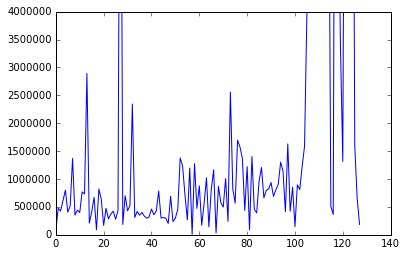

In [76]:
plot(1/norms)
ylim(0,4e6)

In [77]:
mask = 1/norms > 4e6

In [79]:
mask.shape

(128, 1)

In [80]:
lpxn[mask[:,0],:] = 0

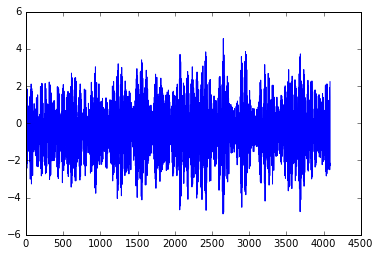

In [81]:
plot(lpxn[7,:])

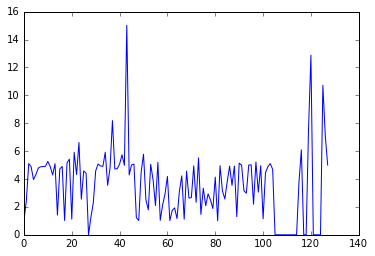

In [82]:
plot(np.abs(lpxn).max(1))

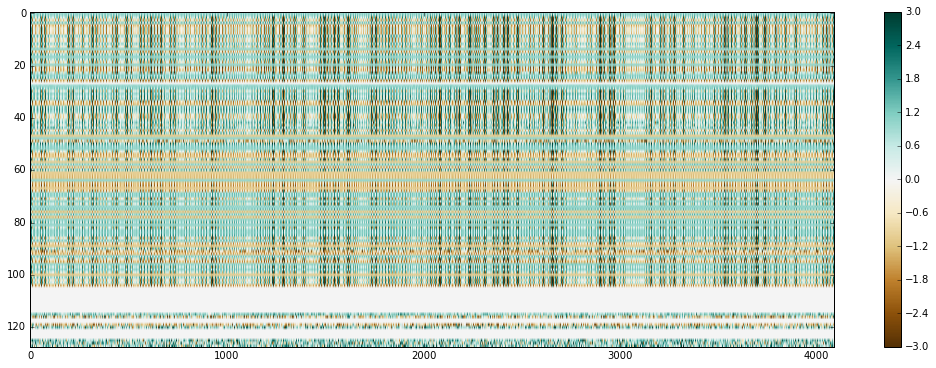

In [95]:
figure(figsize=(18,6))
imshow(lpxn,aspect='auto',cmap=cm.BrBG)
colorbar()
clim(-3,3)

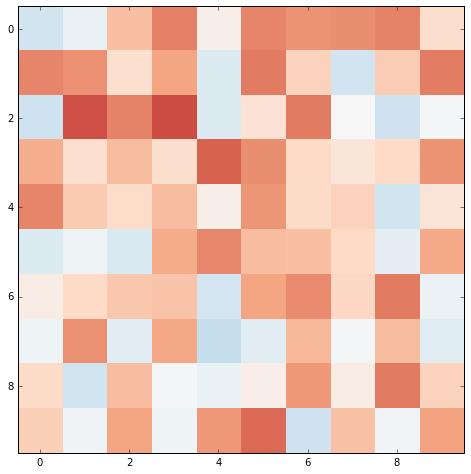

In [99]:
figure(figsize(8,8))
imshow(lpxn[:100,4].reshape((10,10)),aspect='auto',interpolation='nearest',cmap=cm.RdBu)
clim(-5,5)

In [100]:
512e6/2**22

122.0703125

In [94]:
np.save('/artemis/readout/archive/2016-09-16-low-pass-normalized-x.npy',lpxn)

In [35]:
lpx=lpxs[0]

In [30]:
lpx.shape

(4088,)

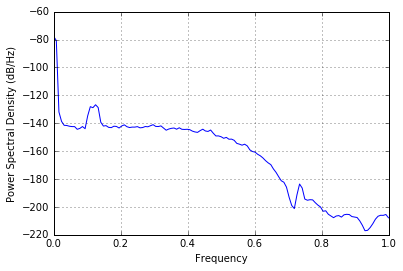

In [36]:
_=psd(lpx)

In [12]:
ssa = ssas[0]

In [22]:
ss = ssa.sweep_streams[40]

(0, 500)

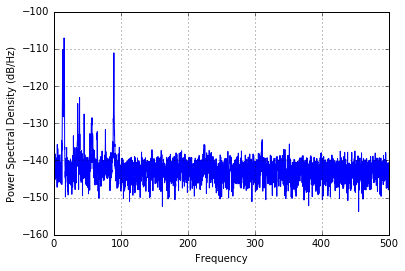

In [25]:
_=psd(ss.x,Fs=ss.stream.stream_sample_rate,NFFT=2**18)
xlim(0,500)

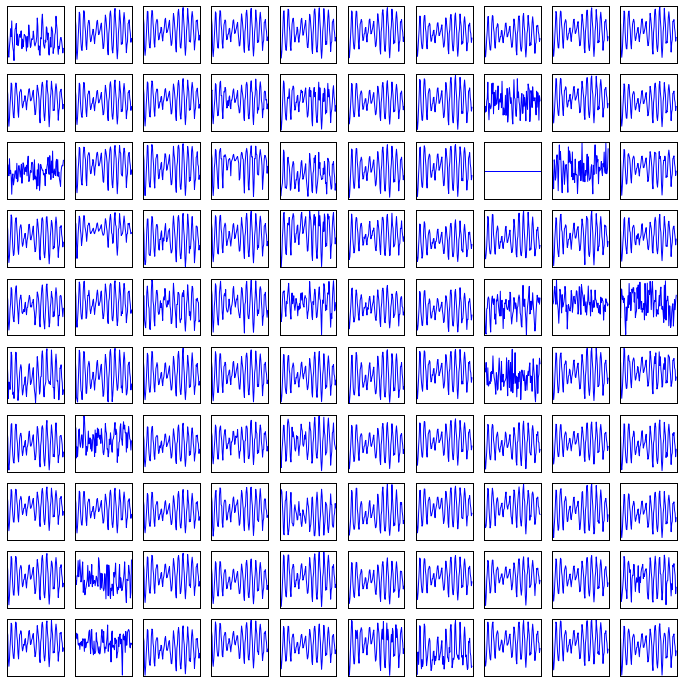

In [111]:
fig,axs = subplots(10,10,figsize=(12,12))
for k, ax in enumerate(axs.flatten()):
    ax.plot(lpxn[k,:100])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [113]:
tuple(range(3))

(0, 1, 2)

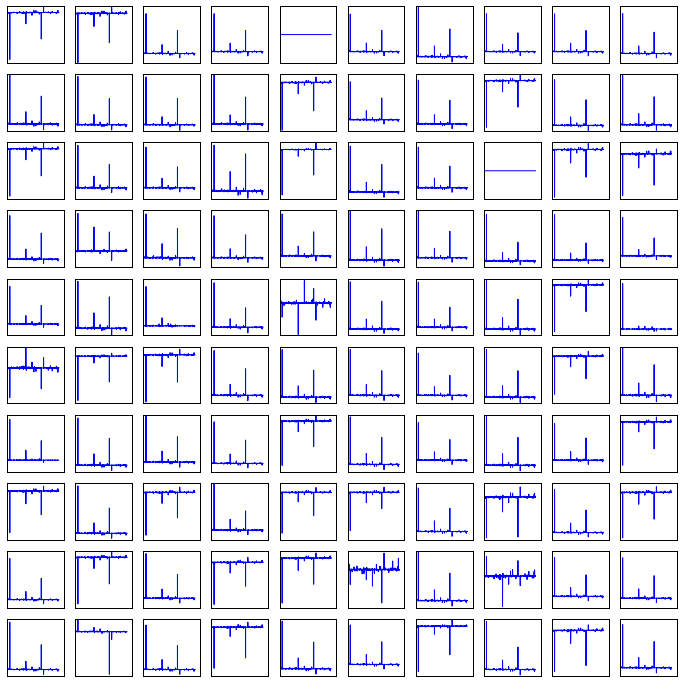

In [108]:
fig,axs = subplots(10,10,figsize=(12,12))
for k, ax in enumerate(axs.flatten()):
    ax.plot(lpxn[k,:]/lpxn[4,:])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [9]:
ss = ss0s[0]

In [ ]:
ss.

In [9]:
ss.stream.roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr18gb_2016_Jun_30_1104.bof', u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 1010000000.0, u'adc_sample_rate': 512000000.0, u'num_tones': 128, u'waveform_normalization': 0.000396728515625, u'modulation_output': 2, u'modulation_rate': 7, u'debug_register': 0, u'fft_shift_register': 1048512, u'num_tone_samples': 131072, u'bank': 0, u'dac_attenuation': 2.0, u'heterodyne': True})

# Sweeps

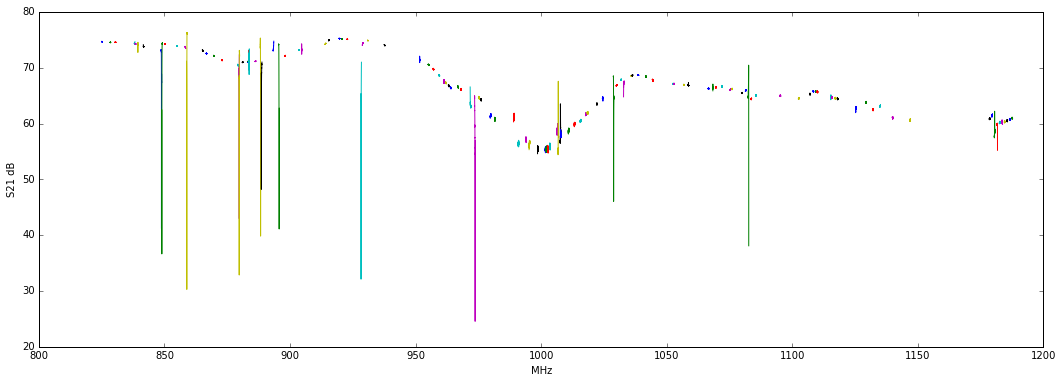

In [10]:
figure(figsize=(18,6))
for ss in ssas[0]:
    plot(ss.sweep.frequency_MHz,dB(ss.sweep.s21_point))
ylabel('S21 dB')
xlabel('MHz')

# Noise for one resonator

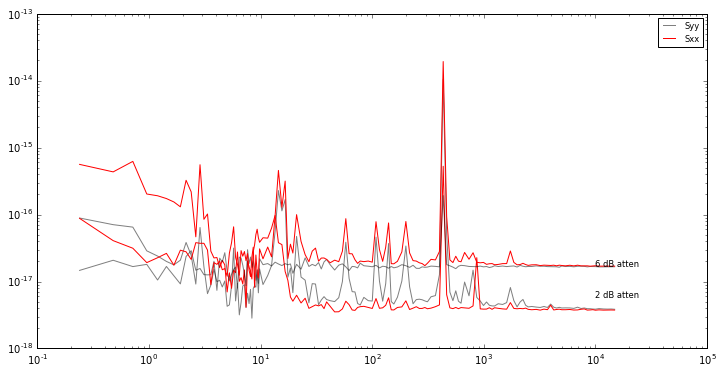

In [11]:
figure(figsize=(12,6))
rlabel = 'Sxx'
glabel = 'Syy'
for ssa in ssas:
    ss = ssa.sweep_streams[7]
    loglog(ss.S_frequency,ss.S_yy,'k',alpha=0.5,label=glabel)
    loglog(ss.S_frequency,ss.S_xx,'r',label=rlabel)
    text(1e4,np.median(ss.S_yy),('%.0f dB atten' % ss.stream.roach_state['dac_attenuation']),size='small')
    rlabel=None
    glabel=None
legend(loc='upper right',prop=dict(size='small'))

# Noise at 2 dB DAC attenuation

In [12]:
sweep_streams = ssas[0].sweep_streams

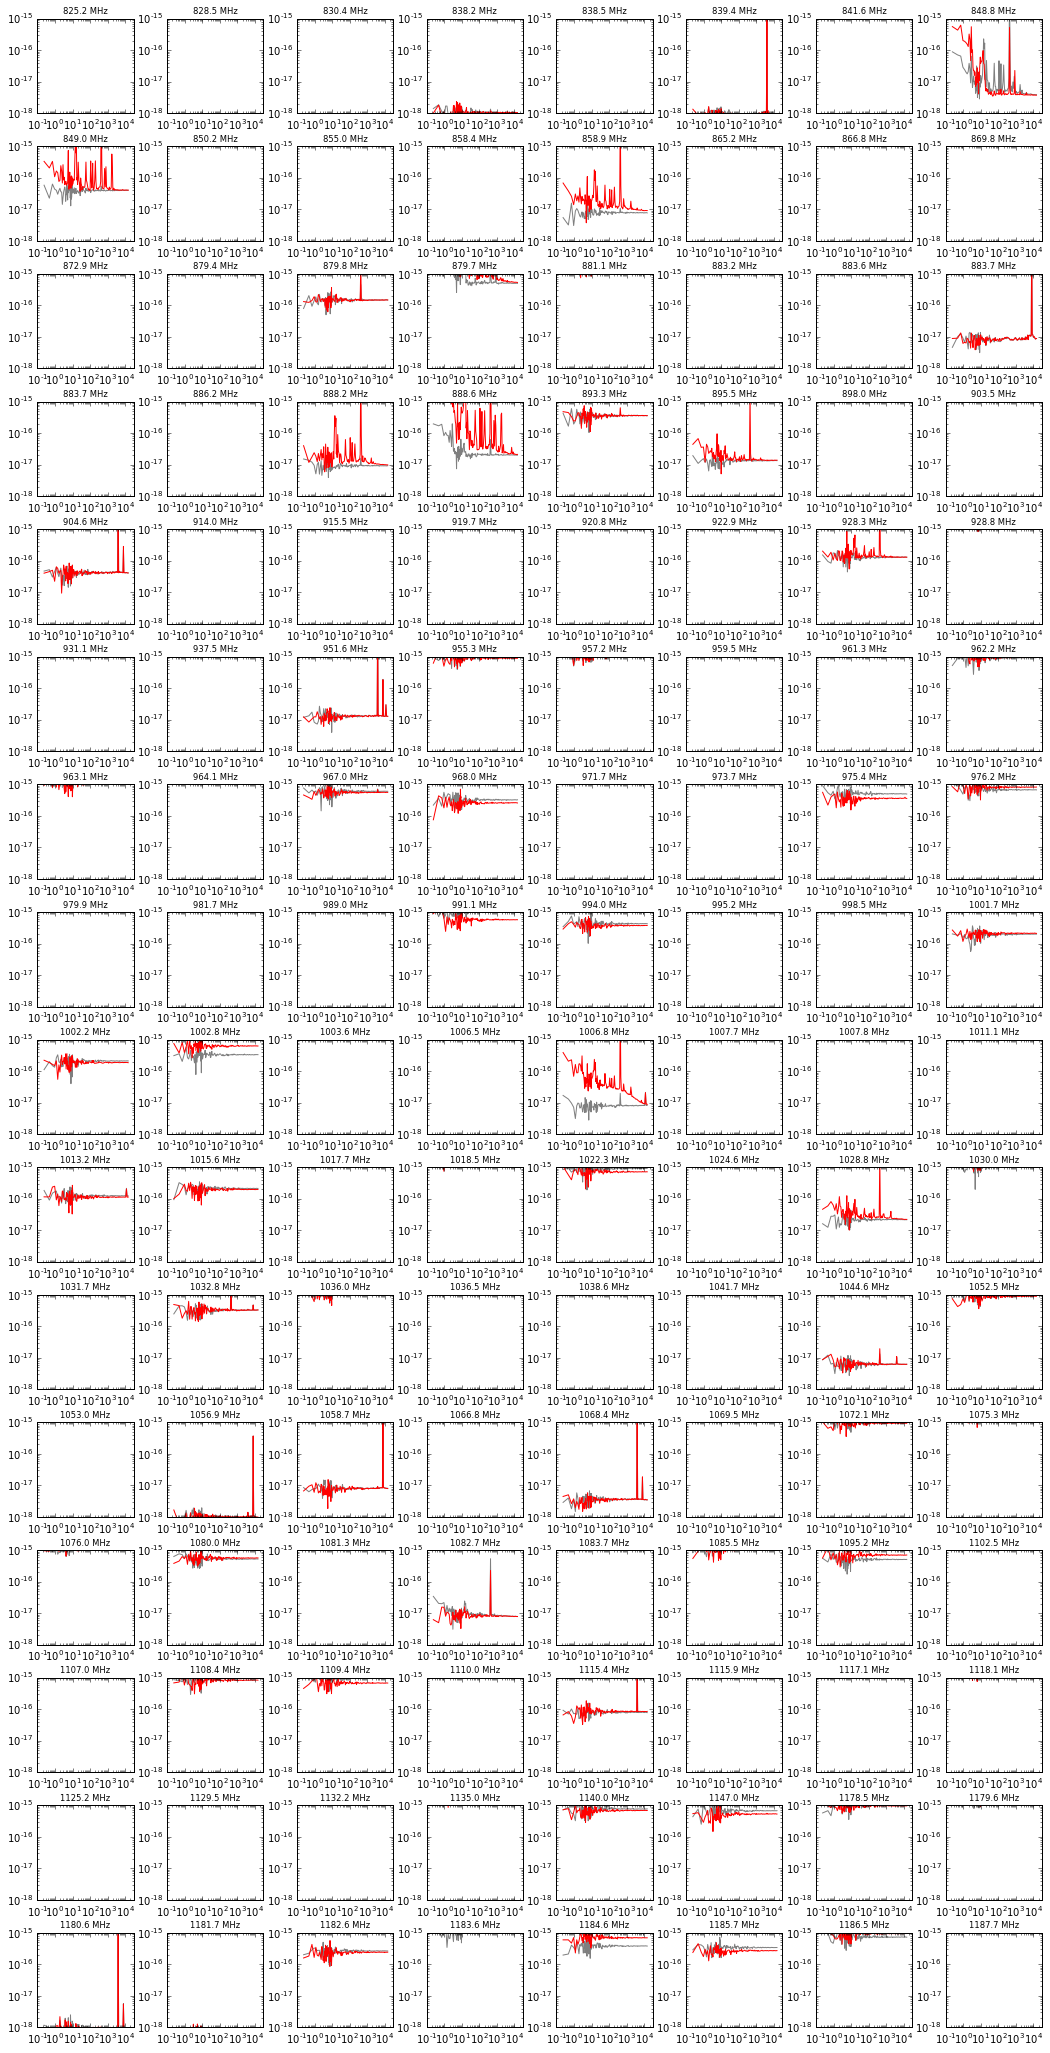

In [13]:
fig,axs = subplots(16,8,figsize=(18,36))
fig.subplots_adjust(wspace=0.35,hspace=0.35)
for k,ax in enumerate(axs.flatten()):
    ss = sweep_streams[k]
    ax.loglog(ss.S_frequency,ss.S_yy,'k',alpha=0.5)
    ax.loglog(ss.S_frequency,ss.S_xx,'r')
    ax.set_ylim(1e-18,1e-15)
    ax.set_xlim(1e-1,3e4)
    ax.set_title(('%.1f MHz' % (ss.resonator.f_0/1e6)),size='small')

# IQ Sweeps

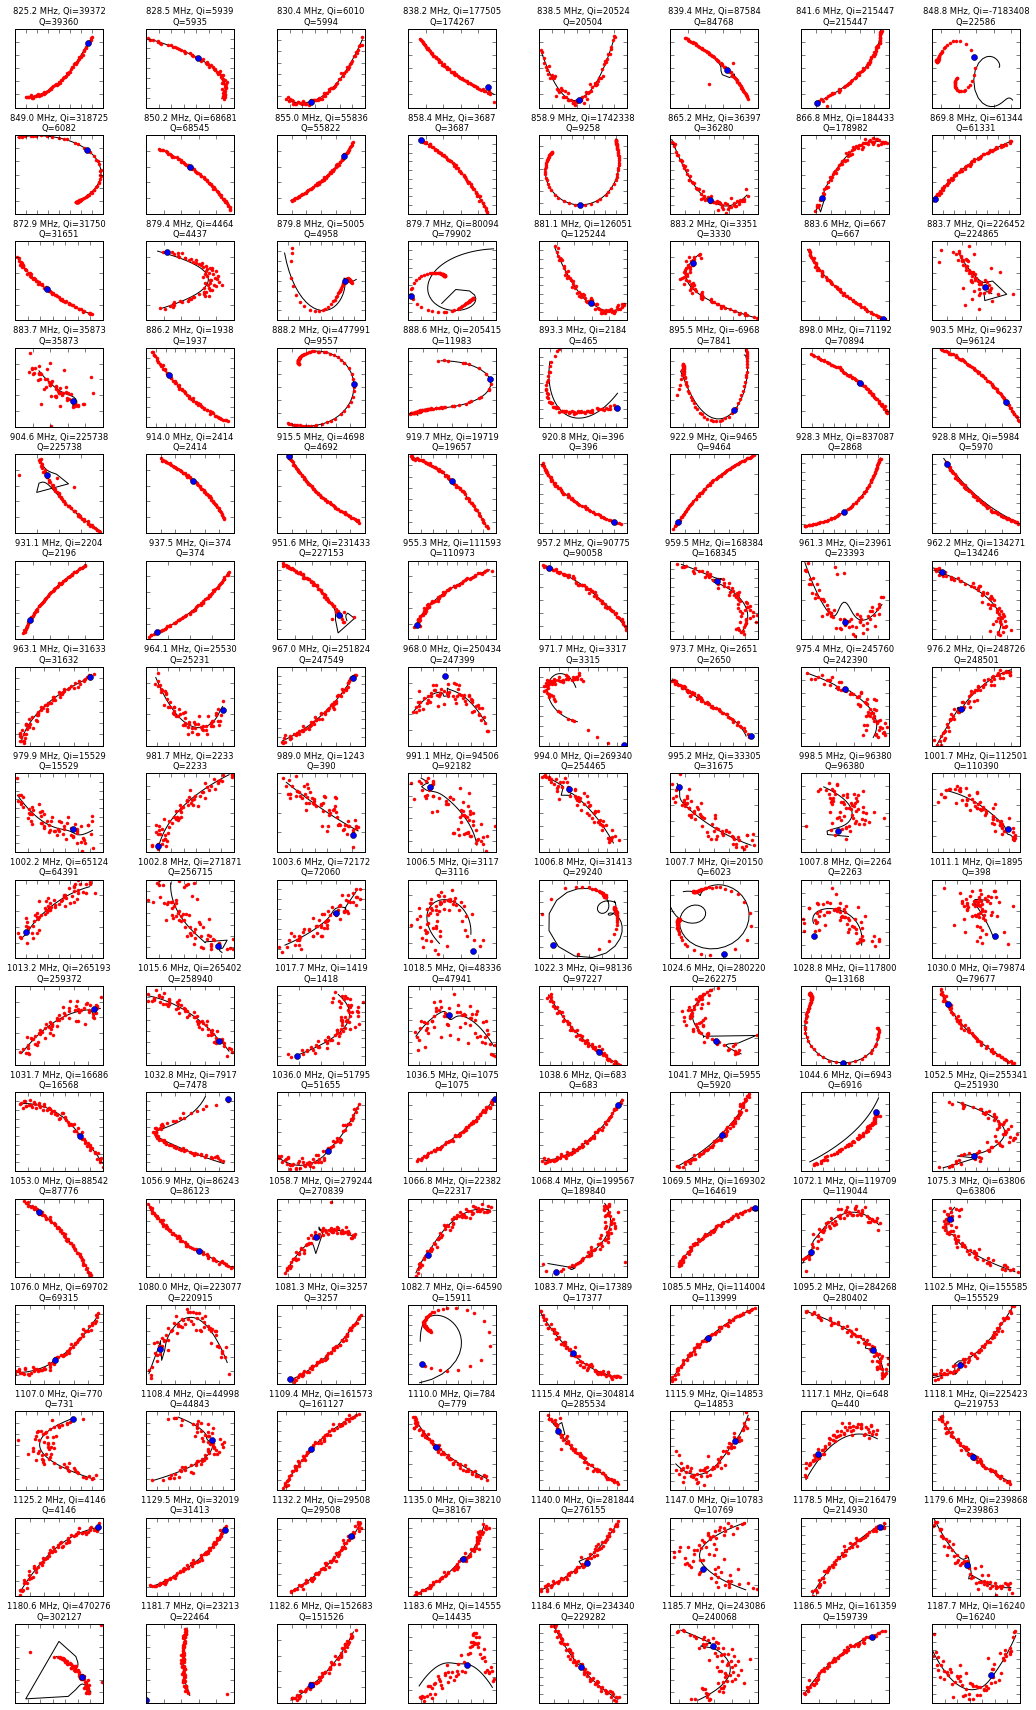

In [14]:
fig,axs = subplots(16,8,figsize=(18,30))
fig.subplots_adjust(wspace=0.5,hspace=0.35)
for k,ax in enumerate(axs.flatten()):
    ss = sweep_streams[k]
    model_s21 = ss.resonator.model.eval(params=ss.resonator.current_params,f=ss.sweep.frequency)
    ax.plot(model_s21.real,model_s21.imag,'k')
    ax.plot(ss.sweep.s21_point.real,ss.sweep.s21_point.imag,'r.')
    ax.plot(ss.stream.s21_point.real,ss.stream.s21_point.imag,'bo')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_title(('%.1f MHz, Qi=%.0f\nQ=%.0f' % (ss.resonator.f_0/1e6, ss.resonator.Q_i,ss.resonator.Q)),size='small')


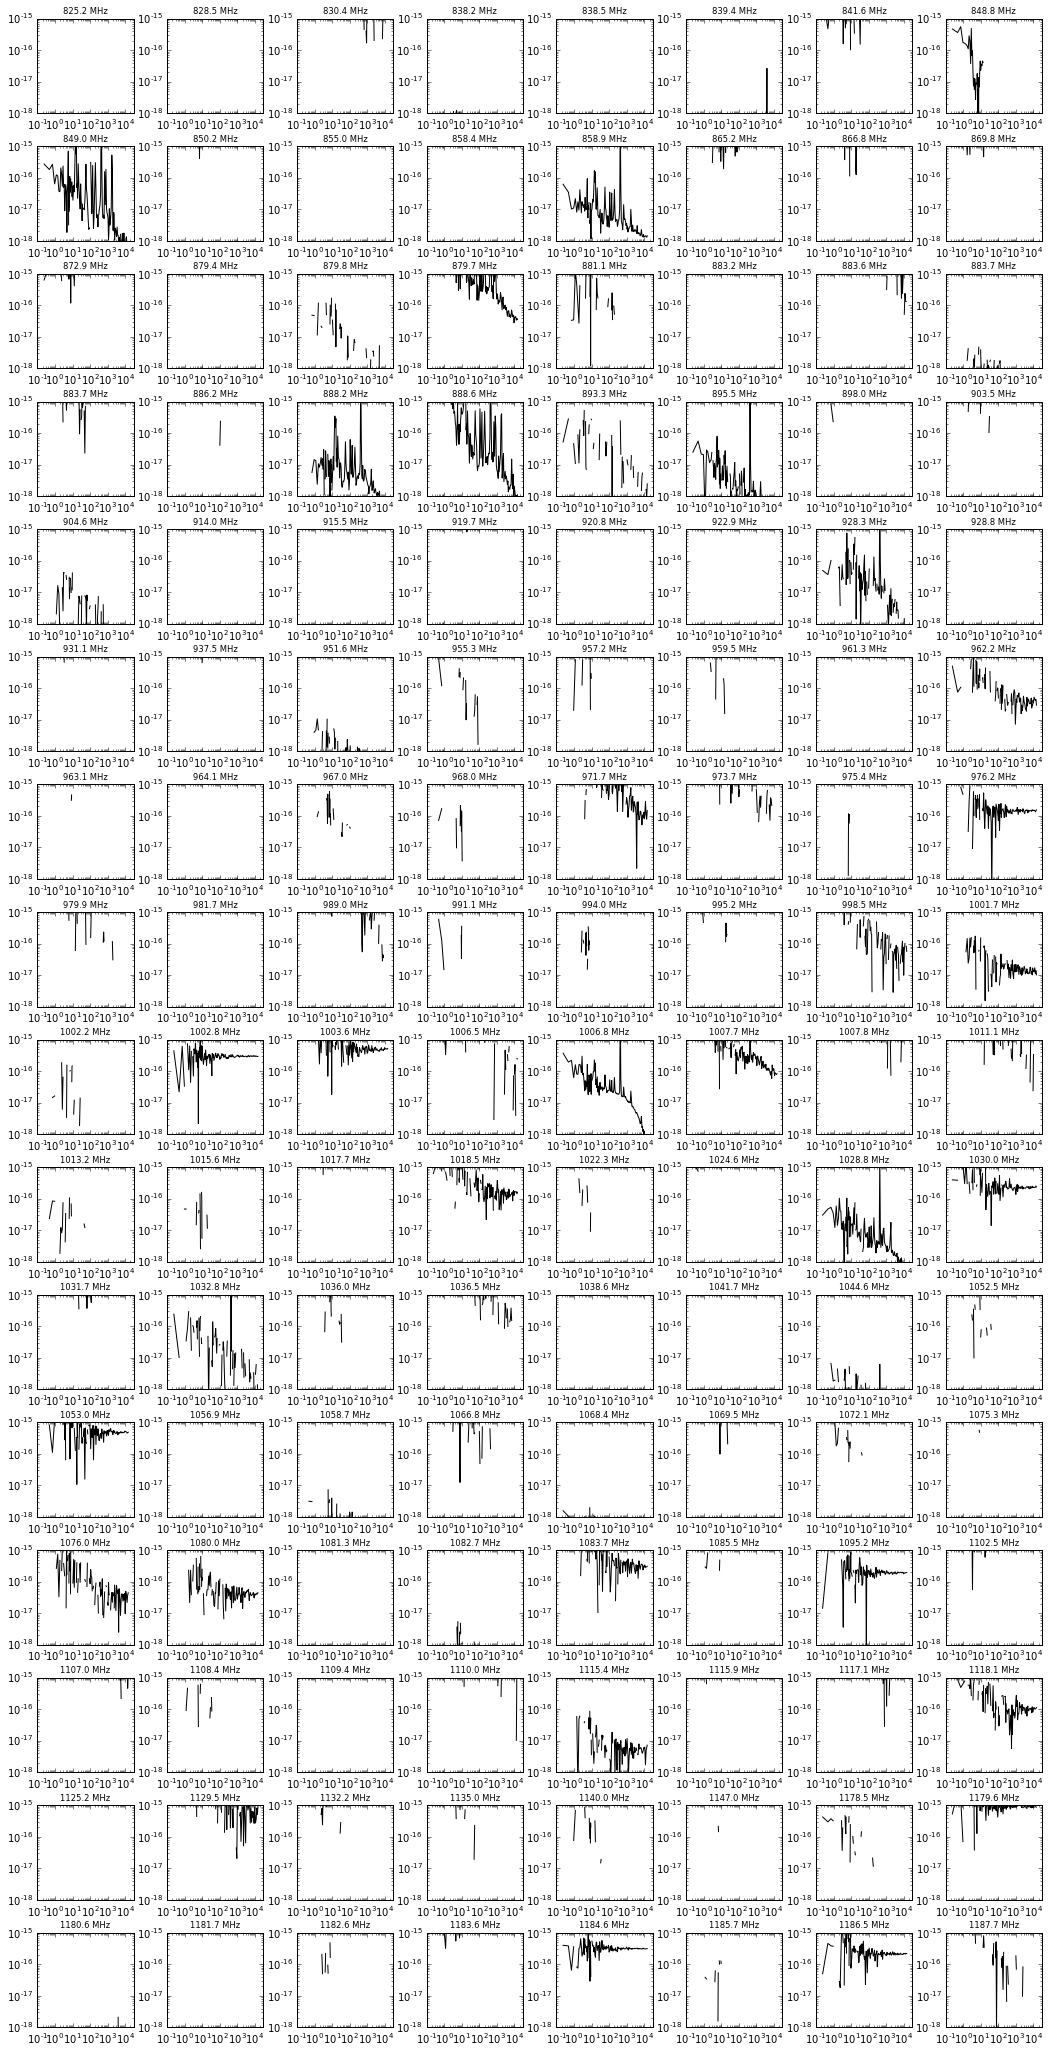

In [15]:
fig,axs = subplots(16,8,figsize=(18,36))
fig.subplots_adjust(wspace=0.35,hspace=0.35)
for k,ax in enumerate(axs.flatten()):
    ss = sweep_streams[k]
    try:
        ax.loglog(ss.S_frequency,ss.S_xx-ss.S_yy,'k')
    except:
        pass
    ax.set_ylim(1e-18,1e-15)
    ax.set_xlim(1e-1,3e4)
    ax.set_title(('%.1f MHz' % (ss.resonator.f_0/1e6)),size='small')

In [38]:
ssa =ssas[-1]

In [39]:
f0s = [ss.resonator.f_0 for ss in  ssa.sweep_streams]

In [41]:
np.save('/home/gjones/2016-08-22-jpl-hf-1-measured-f0s.npy',np.array(f0s))

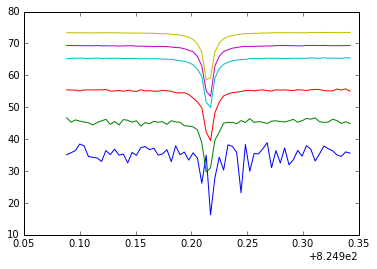

In [10]:
for ss in ss0s:
    plot(ss.sweep.frequency_MHz,dB(ss.sweep.s21_point))

32001.9100006 2689.3910471
43108.8328187 624.616593908
37218.0972704 260.504906415
39318.9295318 61.8916512223
38912.5507136 53.2187151002
39146.3350759 33.6850155282


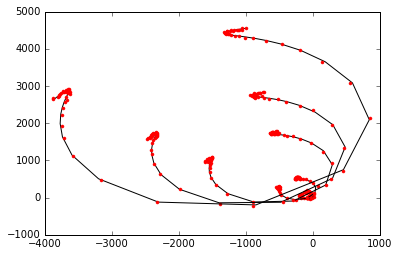

In [15]:
figure()
ax = gca()
for ss in ss0s:
    model_s21 = ss.resonator.model.eval(params=ss.resonator.current_params,f=ss.sweep.frequency)
    ax.plot(model_s21.real,model_s21.imag,'k')
    ax.plot(ss.sweep.s21_point.real,ss.sweep.s21_point.imag,'r.')
    print ss.resonator.Q, ss.resonator.f_0_error


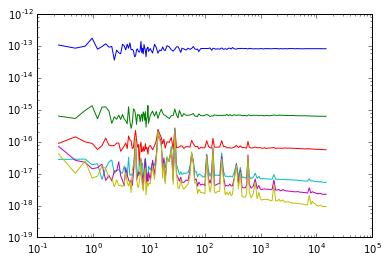

In [24]:
figure()
ax = gca()
for ss in ss0s:
    ax.loglog(ss.S_frequency,ss.S_xx)


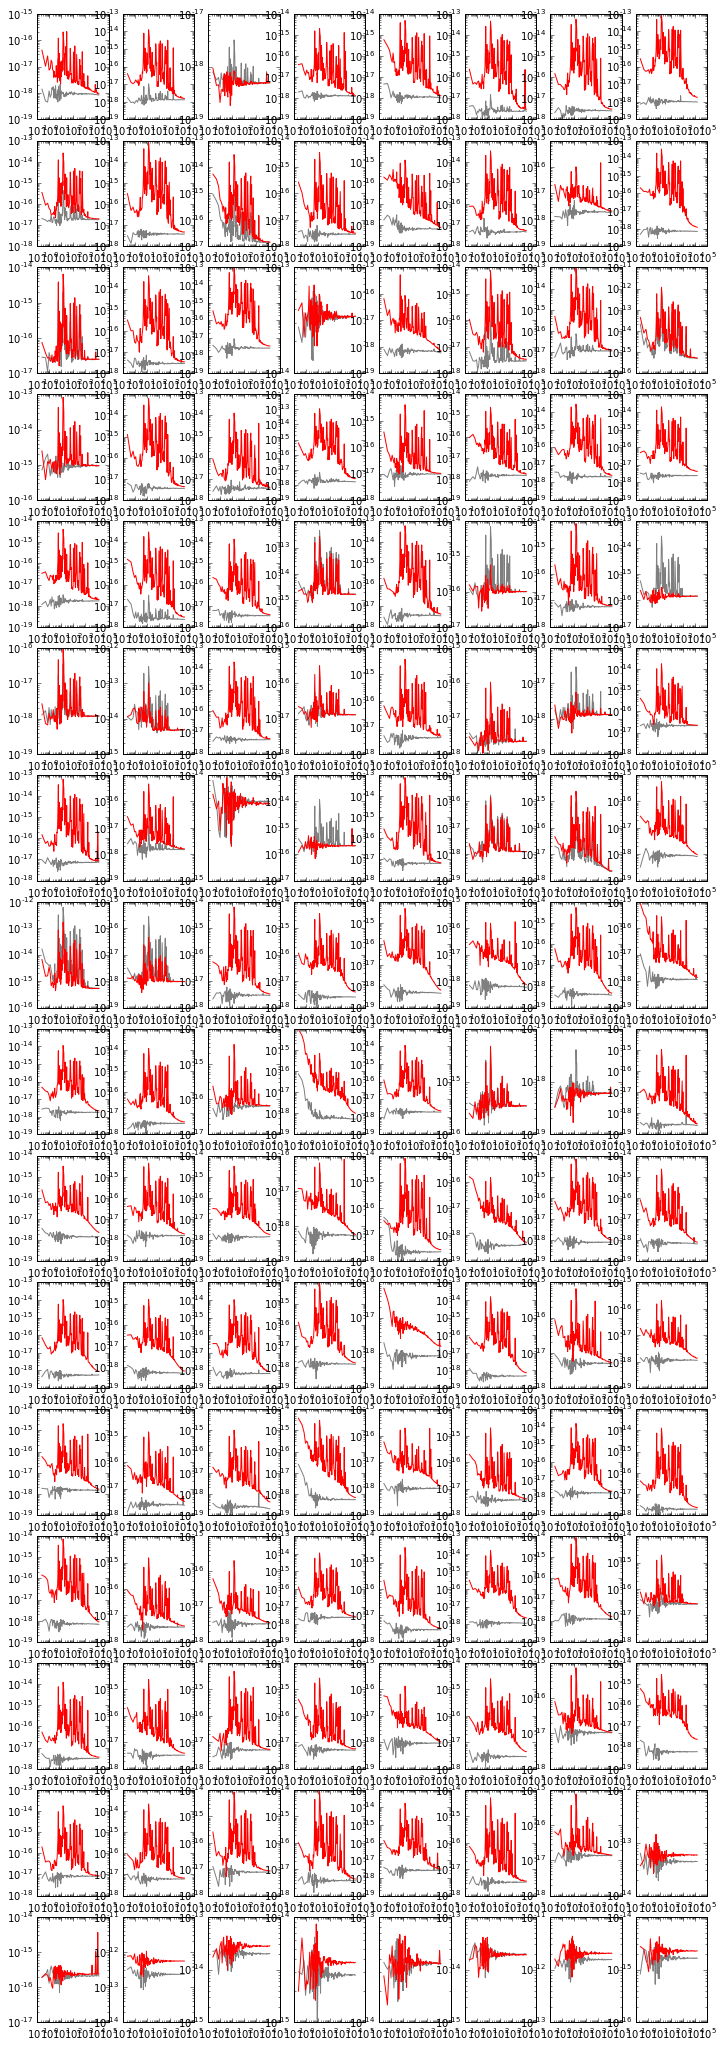

In [32]:
fig,axs = subplots(16,8,figsize=(12,36))
for k,ax in enumerate(axs.flatten()):
    ss = sweep_streams[k]
    ax.loglog(ss.S_frequency,ss.S_yy,'k',alpha=0.5)
    ax.loglog(ss.S_frequency,ss.S_xx,'r')

In [58]:
ss = sweep_streams[7]

In [59]:
ss.set_q_and_x(deglitch=False)

In [60]:
ss.set_S()

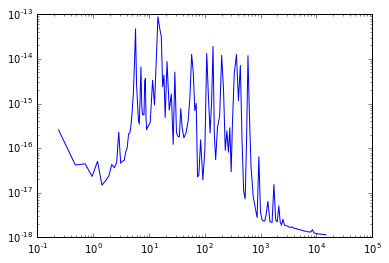

In [61]:
loglog(ss.S_frequency,ss.S_xx)

In [68]:
ss0 = sweep_streams[0]

In [88]:
s = np.array([ss.S_xx-ss.S_yy for ss in sweep_streams])

In [89]:
s.shape

(128, 146)

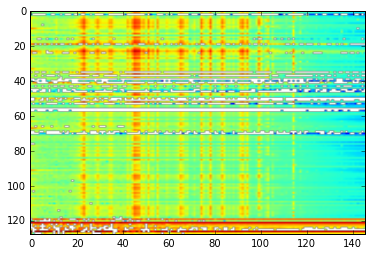

In [90]:
imshow(np.log10(s),aspect='auto')

(0, 1000)

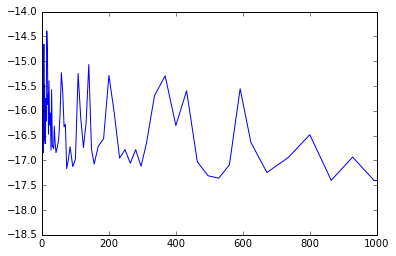

In [98]:
plot(ss.S_frequency,np.log10(np.median(s[:118,:],axis=0)))
xlim(0,1000)

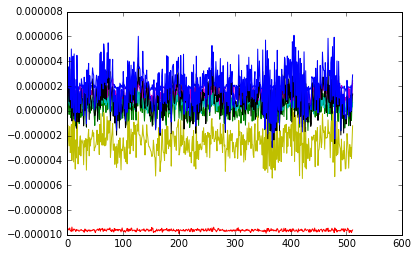

In [95]:
for ss in sweep_streams[:8]:
    plot(ss.x[:2**14:32])

In [ ]:
import kid_readuot.analy